In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.14.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## CNN 

### Single-step model 

In [9]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

In [10]:
# Values obtained from chapter 15

mae_val = [0.083, 0.068, 0.033, 0.03]
mae_test = [0.081, 0.068, 0.029, 0.026]

In [11]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0182 - mean_absolute_error: 0.0922 - val_loss: 0.0060 - val_mean_absolute_error: 0.0577
Epoch 2/50
384/384 [==============================] - 0s 977us/step - loss: 0.0056 - mean_absolute_error: 0.0548 - val_loss: 0.0041 - val_mean_absolute_error: 0.0473
Epoch 3/50
384/384 [==============================] - 0s 988us/step - loss: 0.0043 - mean_absolute_error: 0.0477 - val_loss: 0.0033 - val_mean_absolute_error: 0.0428
Epoch 4/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_absolute_error: 0.0438 - val_loss: 0.0032 - val_mean_absolute_error: 0.0407
Epoch 5/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0032 - mean_absolute_error: 0.0411 - val_loss: 0.0028 - val_mean_absolute_error: 0.0379
Epoch 6/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0030 - mean_absolute_error: 0.0396 - val_loss: 0.0024 - val_mean_absolute_error: 0.0348
Epoch 7/50
3

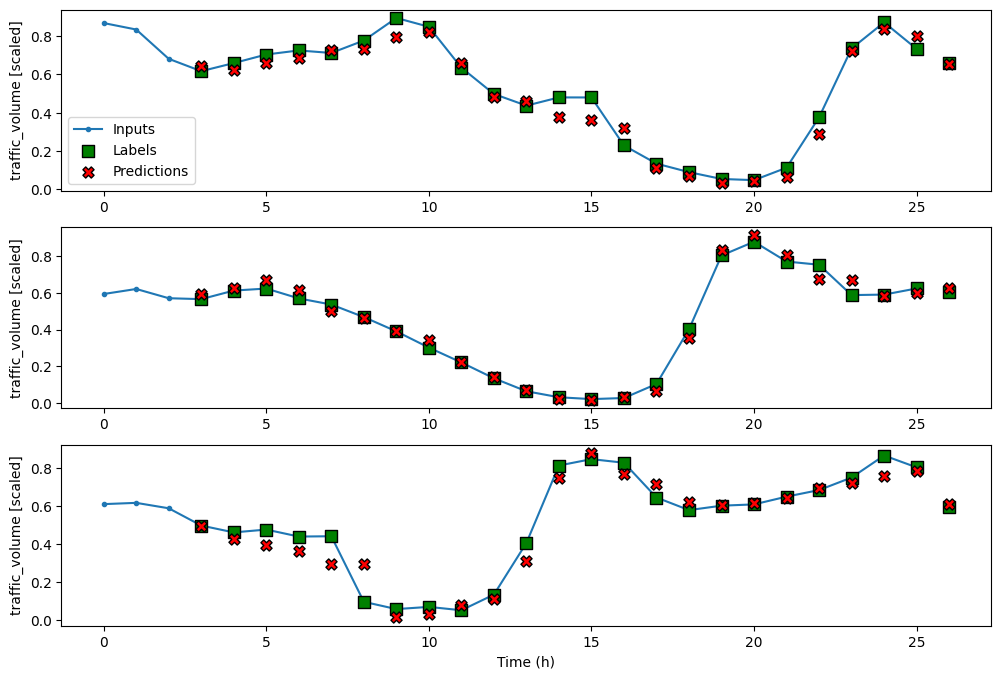

In [12]:
wide_conv_window.plot(cnn_model)

plt.savefig('figures/CH16_F05_peixeiro.png', dpi=300)

#### CNN + LSTM 

In [13]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 4s 3ms/step - loss: 0.0318 - mean_absolute_error: 0.1161 - val_loss: 0.0064 - val_mean_absolute_error: 0.0584
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0062 - mean_absolute_error: 0.0575 - val_loss: 0.0049 - val_mean_absolute_error: 0.0509
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0051 - mean_absolute_error: 0.0519 - val_loss: 0.0040 - val_mean_absolute_error: 0.0459
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0044 - mean_absolute_error: 0.0491 - val_loss: 0.0034 - val_mean_absolute_error: 0.0442
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0038 - mean_absolute_error: 0.0452 - val_loss: 0.0033 - val_mean_absolute_error: 0.0426
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0035 - mean_absolute_error: 0.0429 - val_loss: 0.0039 - val_mean_absolute_error: 0.0502
Epoch 7/50
384/3

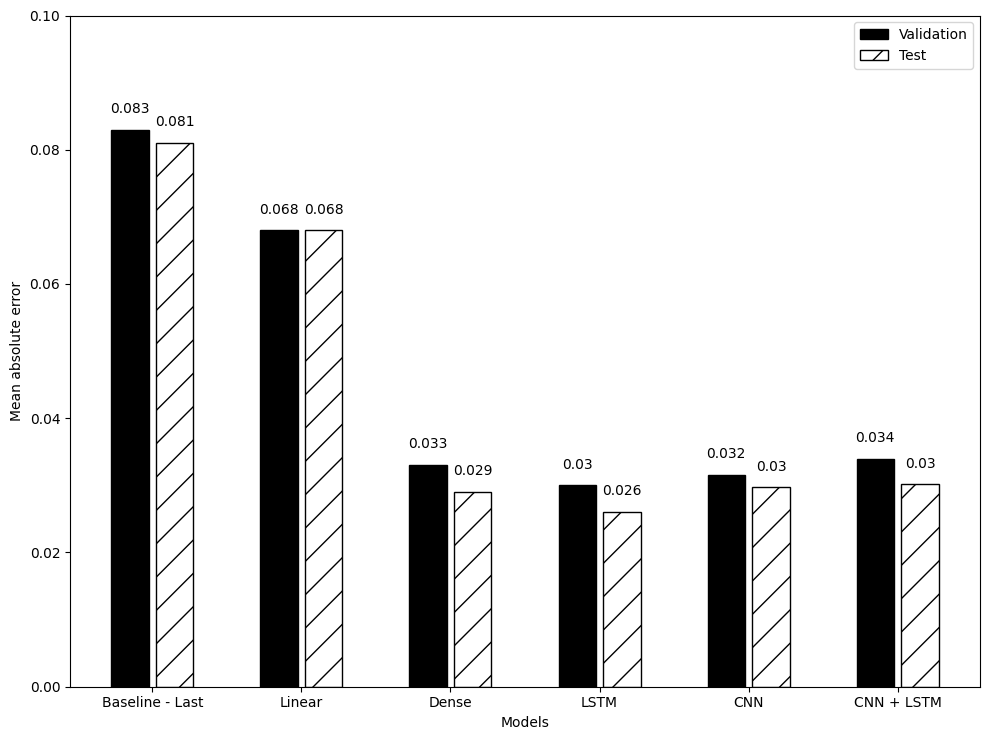

In [14]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH16_F06_peixeiro.png', dpi=300)

### Multi-step model 

In [15]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

In [16]:
# Values obtained from chapter 15

ms_mae_val = [0.352, 0.347, 0.088, 0.078, 0.070]
ms_mae_test = [0.347, 0.341, 0.076, 0.064, 0.058]

In [17]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0351 - mean_absolute_error: 0.1262 - val_loss: 0.0165 - val_mean_absolute_error: 0.0853
Epoch 2/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0141 - mean_absolute_error: 0.0794 - val_loss: 0.0156 - val_mean_absolute_error: 0.0834
Epoch 3/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0136 - mean_absolute_error: 0.0779 - val_loss: 0.0153 - val_mean_absolute_error: 0.0853
Epoch 4/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0133 - mean_absolute_error: 0.0772 - val_loss: 0.0147 - val_mean_absolute_error: 0.0791
Epoch 5/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0132 - mean_absolute_error: 0.0768 - val_loss: 0.0148 - val_mean_absolute_error: 0.0819
Epoch 6/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0130 - mean_absolute_error: 0.0761 - val_loss: 0.0144 - val_mean_absolute_error: 0.0796
Epoch 7/50
383/3

#### CNN + LSTM 

In [18]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 3s 5ms/step - loss: 0.0398 - mean_absolute_error: 0.1391 - val_loss: 0.0173 - val_mean_absolute_error: 0.0892
Epoch 2/50
383/383 [==============================] - 2s 4ms/step - loss: 0.0147 - mean_absolute_error: 0.0820 - val_loss: 0.0164 - val_mean_absolute_error: 0.0848
Epoch 3/50
383/383 [==============================] - 2s 4ms/step - loss: 0.0142 - mean_absolute_error: 0.0799 - val_loss: 0.0160 - val_mean_absolute_error: 0.0823
Epoch 4/50
383/383 [==============================] - 2s 4ms/step - loss: 0.0138 - mean_absolute_error: 0.0783 - val_loss: 0.0153 - val_mean_absolute_error: 0.0793
Epoch 5/50
383/383 [==============================] - 2s 4ms/step - loss: 0.0134 - mean_absolute_error: 0.0765 - val_loss: 0.0152 - val_mean_absolute_error: 0.0769
Epoch 6/50
383/383 [==============================] - 2s 4ms/step - loss: 0.0130 - mean_absolute_error: 0.0749 - val_loss: 0.0142 - val_mean_absolute_error: 0.0787
Epoch 7/50
383/3

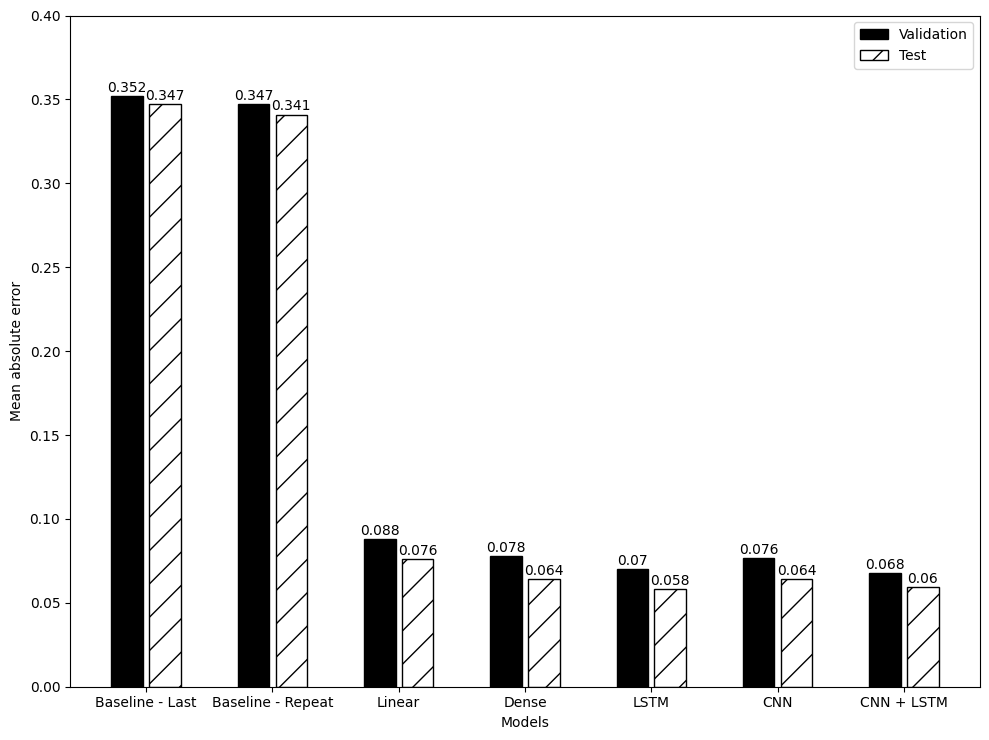

In [19]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(7)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH16_F07_peixeiro.png', dpi=300)

### Multi-output model 

In [20]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

In [21]:
# Values from chapter 15

mo_mae_val = [0.048, 0.039, 0.023, 0.020]
mo_mae_test = [0.047, 0.036, 0.020, 0.017]

In [22]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0132 - mean_absolute_error: 0.0666 - val_loss: 0.0028 - val_mean_absolute_error: 0.0358
Epoch 2/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0025 - mean_absolute_error: 0.0331 - val_loss: 0.0019 - val_mean_absolute_error: 0.0307
Epoch 3/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0020 - mean_absolute_error: 0.0287 - val_loss: 0.0015 - val_mean_absolute_error: 0.0261
Epoch 4/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0018 - mean_absolute_error: 0.0267 - val_loss: 0.0014 - val_mean_absolute_error: 0.0256
Epoch 5/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0016 - mean_absolute_error: 0.0256 - val_loss: 0.0013 - val_mean_absolute_error: 0.0238
Epoch 6/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0016 - mean_absolute_error: 0.0249 - val_loss: 0.0012 - val_mean_absolute_error: 0.0236
Epoch 7/50
384/3

In [23]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 3s 5ms/step - loss: 0.0159 - mean_absolute_error: 0.0785 - val_loss: 0.0040 - val_mean_absolute_error: 0.0443
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0029 - mean_absolute_error: 0.0364 - val_loss: 0.0019 - val_mean_absolute_error: 0.0307
Epoch 3/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0299 - val_loss: 0.0015 - val_mean_absolute_error: 0.0269
Epoch 4/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0275 - val_loss: 0.0014 - val_mean_absolute_error: 0.0258
Epoch 5/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0263 - val_loss: 0.0017 - val_mean_absolute_error: 0.0321
Epoch 6/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0256 - val_loss: 0.0013 - val_mean_absolute_error: 0.0237
Epoch 7/50
384/3

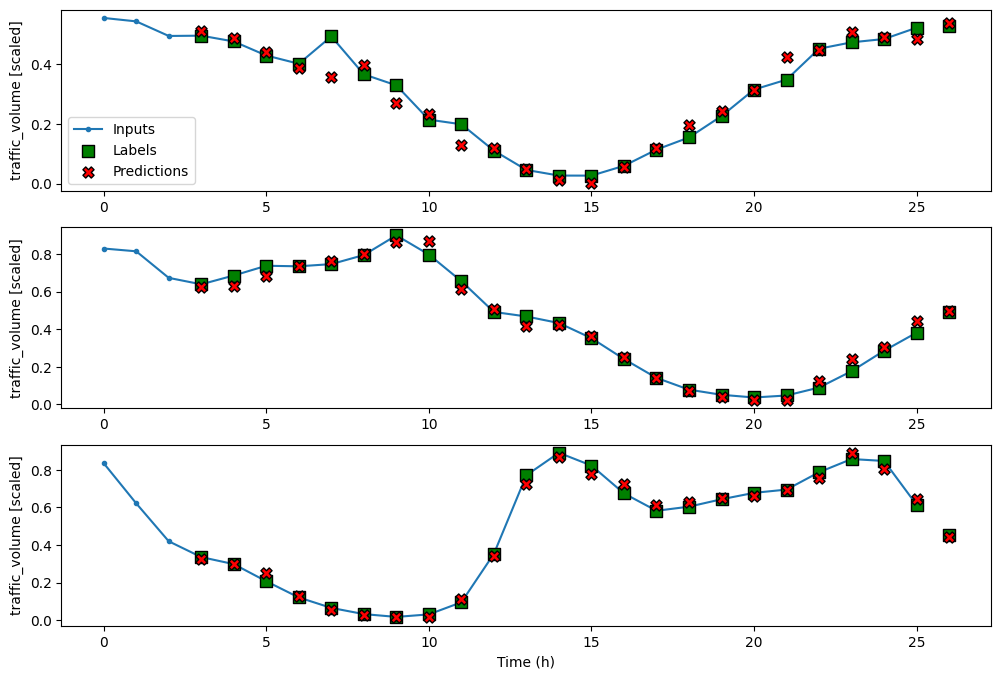

In [24]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

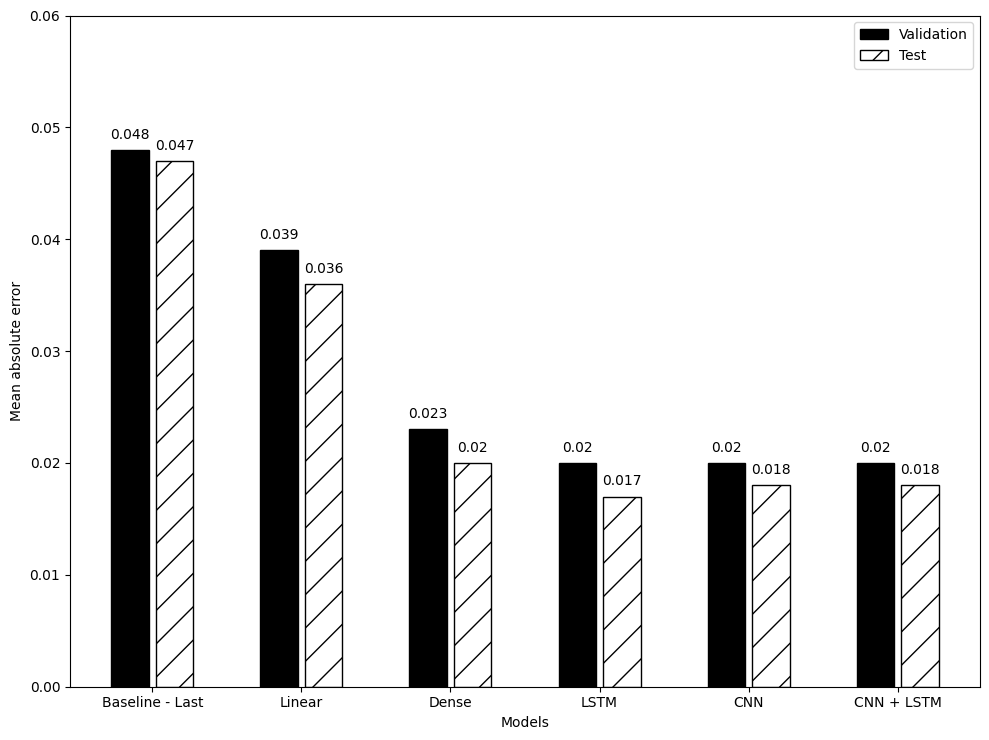

In [25]:
mo_mae_val.extend([v[1] for v in mo_val_performance.values()])
mo_mae_test.extend([v[1] for v in mo_performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH16_F08_peixeiro.png', dpi=300)